# Assigment 3: CAMSHIFT
## Paper
Read the paper "Bradski_etal_1998_camshift.pdf" in KVV (under "Resources/papers"). 

## Calculate histogram
* Implement a function that creates a color histogram. Pass either an image and ROI, or the image underlying the ROI. 
* For this purpose, a second (or third) parameter can be passed to specify the number of bins. 
* Load the image "images/racecar.png" and convert the image to the HSV color space. Plot the Hue channel. (**RESULT**)

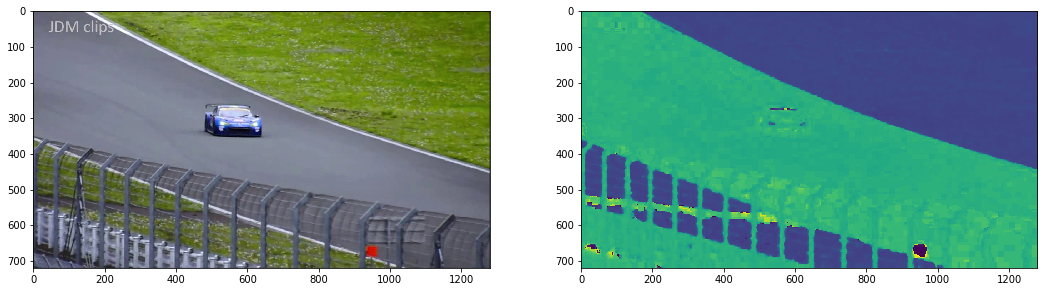

In [38]:
# dieser Code wurde als Musterlösung von Tobias Schülke zur Verfügung gestellt und von Tim renoviert

%matplotlib inline 
from skimage import io, color
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import os
import warnings; warnings.simplefilter('ignore')


IMAGES_PER_ROW = 4

MIN_SATURATION_CAR = 0.2
MIN_VALUE_CAR = 0.5
MIN_SATURATION_TACO = 0.8
MIN_VALUE_TACO = 0.2

ROI_FRAME_MARGIN_CAR = 60
ROI_FRAME_MARGIN_TACO = 20


def create_color_histogram(img, bins=360):
    hues = color.rgb2hsv(img)[:, :, 0]
    return np.histogram(hues, bins=bins, range=(0, 1))

def plot_histogram(ax, hist, bins=360):
    X = range(0, bins)
    hsv_colors = np.array([[h/bins, 1, 1] for h in X])
    rgb_colors = (
        color.hsv2rgb(
            # reshape to make 'hsv2rgb' work because it expects an image
            hsv_colors.reshape((bins, 1, 3))
        )
        .reshape((bins, 3))
    )
    return ax.bar(X, hist, color=rgb_colors)

def create_and_plot_histogram(ax, img, bins=360):
    hist, bin_edges = create_color_histogram(img, bins=bins)
    return hist, plot_histogram(ax, hist, bins=bins)


image = io.imread('images/racecar.png')

fig = plt.figure(figsize=(18, 12))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)

ax1.imshow(image)
ax2.imshow(color.rgb2hsv(image)[:, :, 0])

None

* display the histogram for the Hue channel for the entire image and for the RIO (x,y) = (480, 260) to (640, 350). Vary the number of bins for testing purposes (**RESULT**).

In [ ]:
image_car = image[260:350, 480:640]

fig = plt.figure(figsize=(18, 12))
grid = fig.add_gridspec(5, 2)
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])
ax3 = fig.add_subplot(grid[1, 0])
ax4 = fig.add_subplot(grid[1, 1])
ax5 = fig.add_subplot(grid[2, 0])
ax6 = fig.add_subplot(grid[2, 1])
ax7 = fig.add_subplot(grid[3, :])
ax8 = fig.add_subplot(grid[4, :])

ax1.imshow(image)
ax2.imshow(image_car)
create_and_plot_histogram(ax3, image)
create_and_plot_histogram(ax4, image_car)
create_and_plot_histogram(ax5, image_car, bins=10)
create_and_plot_histogram(ax6, image_car, bins=100)
create_and_plot_histogram(ax7, image_car, bins=1000)
create_and_plot_histogram(ax8, image_car, bins=5000)

None

## probability distribution
* implement the method outlined in the CAMSHIFT paper to create a probability distribution for a given object's hue histogram
* create the histogram of the car from the image "racecar.png" and apply the new function to the last frame of the video (images/racecar/151.jpg) (**RESULT**)


In [2]:
# Tip: in der Nacht sind alle Katzen grau ;)
# def createProbDistribution(image, objectHist, nbins, minSaturation, minValue):
    #...
            
lastFrame = io.imread('images/racecar/151.jpeg')
# histogramCar = createColorHistogram(imageCar, nbins, ax1)
# probDistr = createProbDistribution(lastFrame, histogramCar, nbins, MIN_SATURATION_CAR, MIN_VALUE_CAR)
# io.imshow(probDistr)

### show ROI in image


In [3]:
def drawROI(image, x, y, width, height, out = plt):
    currentAxis = plt.gca()
    currentAxis.add_patch(
        patches.Rectangle(
            (x, y),
            width,
            height,
            fill=False,
            edgecolor="red"
        )
    )
    
    out.imshow(image)

# showRoiFrame(image, 480, 260, 160, 90)

## Exercise 3.2 - Mean Shift
* Implement the Mean Shift method for a ROI as described in the lecture. Test the algorithm on the image sequences "images/racecar/*.jpg" or "images/taco/*.jpg". Select the appropriate tracking window (to reduce the file size I have reduced the images by a factor of 2, i.e. the ROI from above must be adjusted accordingly). 
* Draw the trajectory of the objects as returned by Mean Shift. (**RESULT**)

##  Exercise 3.3 - CAMSHIFT
* extend your algorithm by adjusting the size of the ROI and finding the object's orientation
* execute the algorithm again on one of the image sequences and draw an ellipse on the image, which represents the found parameters (**RESULT**)